In [1]:
import pickle
import numpy as np
import os
from matplotlib import pyplot as plt

## Problem 1: **Examine the HMAX Model**

In [2]:
# examine the dimensions of the HMAX output

hmax_pth = '/home/karnav/Documents/AM9624/labs/L6/2025_wk8_hmax' # replace by your path
os.chdir(hmax_pth) 
output = pickle.load( open('output.pkl', 'rb'))


########## S1 ##########

# s1is a list of 3D arrays
s1 = output['s1']                       
n_sscales = len(s1) # s = spatial

# get the first spatial scale output
s1_sscale1 = s1[0]

print("S1 ----------")
print(f"Spatial scales: {n_sscales}")
print(f"Number of filter types/orientations: {s1_sscale1.shape[1]} (z)")
print(f"Post-filter size: {s1_sscale1.shape[2]} x {s1_sscale1.shape[3]} (x,y)")

x = 250
y = 250
z = 4 

########## C1 ##########

c1 = output['c1']  # C1 is a list of 3D arrays

# number of spatial scales
n_cscales = len(c1)  
c1_sscale1 = c1[0]  

print("\nC1 ----------")
print(f"Spatial scales: {n_cscales}")
print(f"Number of filter types/orientations: {c1_sscale1.shape[1]} (z)")
print(f"Post-pooling size (1st spatial scale): {c1_sscale1.shape[2]} x {c1_sscale1.shape[3]} (n)")

c1_scale2 = c1[1]
print(f"Post-pooling size (2nd spatial scale): {c1_scale2.shape[2]} x {c1_scale2.shape[3]} (m)")

layer_name = "c1"
n = 63
m = 51


########## S2 ##########

s2 = output['s2']
n_fscales = len(s2) # number of filter scales  

# first filter scale
s2_fscale1 = s2[0]

# number of spatial scales in this filter scale 
n_sscales = len(s2_fscale1)
s2_fscale1_sscale1 = s2_fscale1[0]

print("\nS2 ----------")
print(f"Spatial scales: {n_fscales}")
print(f"Shape for a single spatial scale {s2_fscale1_sscale1.shape}")
print(f"Number of filter types/orientations: {s2_fscale1_sscale1.shape[1]} (s)")

operation_A = "patch matching (filters/matches with 'known' patches)"
s = 400

########## C2 ##########

c2 = output['c2']
print(f"C2 shape: {c2[0].shape}")

operation_B = "max-pooling"

# save answers
# insert x, y, z, m, n, s (integers), and layer name, operation A, operation B (strings) ...
#    ... as values in the dictionary below and save the dictionary as a text file using the code below


dict = {'x':  x, 'y':  y, 'z':  z, 'm':  m, 'n':  n, 's':  s, 'layer name':  layer_name, 'operation A':  operation_A, 'operation B':  operation_B } 
f = open('wk8_prob1.txt', 'w')
f.writelines( [str(dict['x'])+'\n', str(dict['y'])+'\n', str(dict['z'])+'\n', str(dict['m'])+'\n', str(dict['n'])+'\n', str(dict['s'])+'\n', dict['layer name']+'\n', dict['operation A']+'\n', dict['operation B']] )
f.close()

S1 ----------
Spatial scales: 17
Number of filter types/orientations: 4 (z)
Post-filter size: 250 x 250 (x,y)

C1 ----------
Spatial scales: 8
Number of filter types/orientations: 4 (z)
Post-pooling size (1st spatial scale): 63 x 63 (n)
Post-pooling size (2nd spatial scale): 51 x 51 (m)

S2 ----------
Spatial scales: 8
Shape for a single spatial scale (1, 400, 63, 63)
Number of filter types/orientations: 400 (s)
C2 shape: (1, 400)


## Problem 2: **Visualize HMAX Output**

### (2.1) Visualizing HMAX Responses

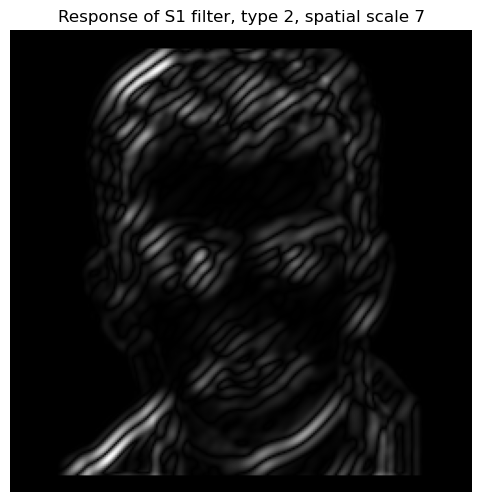

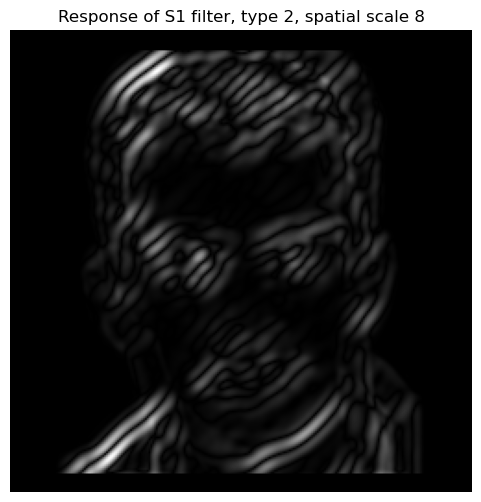

In [3]:
## S1 Response

filter_type = 2
spatial_scales = [7,8]

for s in spatial_scales:
    plt.figure(figsize=(6, 6))
    plt.imshow(s1[s-1][0][filter_type-1, :, :], cmap='gray')
    plt.title(f'Response of S1 filter, type {filter_type}, spatial scale {s}')
    plt.axis('off')
    # plt.show()

    # save 
    plt.savefig(f's1_response_scale{s}_type{filter_type}.png', dpi=300, bbox_inches='tight')

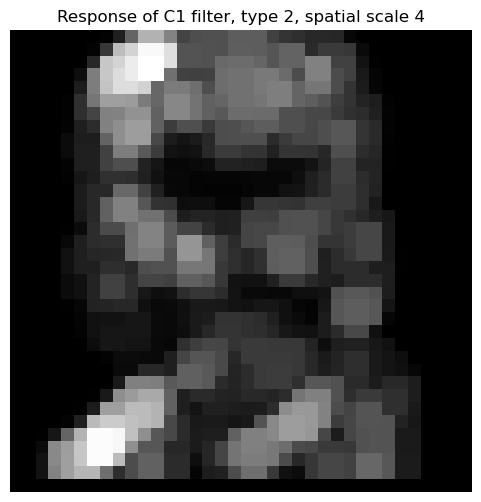

In [4]:
## C1 Response

filter_type = 2
spatial_scale = 4

plt.figure(figsize=(6, 6))
plt.imshow(c1[spatial_scale-1][0][filter_type-1, :, :], cmap='gray')
plt.title(f'Response of C1 filter, type {filter_type}, spatial scale {spatial_scale}')
plt.axis('off')
plt.savefig(f'c1_response_scale{spatial_scale}_type{filter_type}.png', dpi=300, bbox_inches='tight')

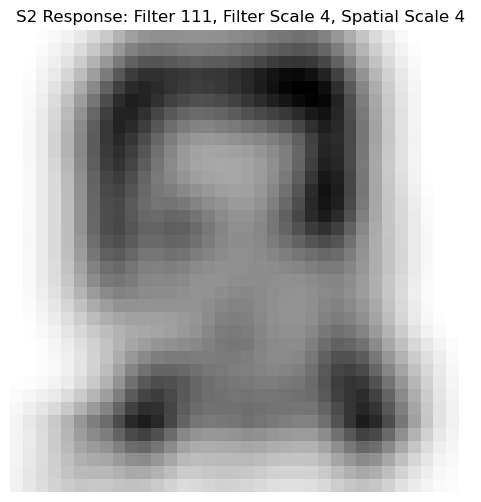

In [5]:
## S2 Response

filter_type = 111 
filter_scale = 4  
spatial_scale = 4 

plt.figure(figsize=(6, 6))
plt.imshow(s2[filter_scale-1][spatial_scale-1][0][filter_type-1, :, :], cmap='gray')
plt.title(f'S2 Response: Filter {filter_type}, Filter Scale {filter_scale}, Spatial Scale {spatial_scale}')
plt.axis('off')

plt.savefig(f's2_response_fscale{filter_scale}_sscale{spatial_scale}_type{filter_type}.png', bbox_inches='tight', dpi=300)

### (2.2) Visualizing HMAX Filters

Now let's visualize the filters that created these responses. First I paste in the entire HMAX code. 

In [6]:
# encoding: utf8
r"""
PyTorch implementation of the HMAX model of human vision. For more information
about HMAX, check:

    http://maxlab.neuro.georgetown.edu/hmax.html

The S and C units of the HMAX model can almost be mapped directly onto
TorchVision's Conv2d and MaxPool2d layers, where channels are used to store the
filters for different orientations. However, HMAX also implements multiple
scales, which doesn't map nicely onto the existing TorchVision functionality.
Therefore, each scale has its own Conv2d layer, which are executed in parallel.

Here is a schematic overview of the network architecture:

layers consisting of units with increasing scale
S1 S1 S1 S1 S1 S1 S1 S1 S1 S1 S1 S1 S1 S1 S1 S1
 \ /   \ /   \ /   \ /   \ /   \ /   \ /   \ /
  C1    C1    C1    C1    C1    C1    C1    C1
   \     \     \    |     /     /     /     /
           ALL-TO-ALL CONNECTIVITY
   /     /     /    |     \     \     \     \
  S2    S2    S2    S2    S2    S2    S2    S2
   |     |     |     |     |     |     |     |
  C2    C2    C2    C2    C2    C2    C2    C2

This implementation tries to follow the original MATLAB implementation by
Maximilian Riesenhuber as closely as possible:
https://maxlab.neuro.georgetown.edu/hmax.html

Author: Marijn van Vliet <w.m.vanvliet@gmail.com>

References
----------

  .. [1] Riesenhuber, Maximilian, and Tomaso Poggio. “Hierarchical Models of
         Object Recognition in Cortex.” Nature Neuroscience 2, no. 11 (1999):
         1019–25.  https://doi.org/10.1038/14819.
  .. [2] Serre, T, M Kouh, C Cadieu, U Knoblich, Gabriel Kreiman, and T Poggio.
         “A Theory of Object Recognition: Computations and Circuits in the
         Feedforward Path of the Ventral Stream in Primate Visual Cortex.”
         Artificial Intelligence, no. December (2005): 1–130.
         https://doi.org/10.1.1.207.9279.
  .. [3] Serre, Thomas, Aude Oliva, and Tomaso Poggio. “A Feedforward
         Architecture Accounts for Rapid Categorization.” Proceedings of the
         National Academy of Sciences 104, no. 15 (April 10, 2007): 6424–29.
         https://doi.org/10.1073/pnas.0700622104.
  .. [4] Serre, Thomas, and Maximilian Riesenhuber. “Realistic Modeling of
         Simple and Complex Cell Tuning in the HMAXModel, and Implications for
         Invariant Object Recognition in Cortex.” CBCL Memo, no. 239 (2004).
  .. [5] Serre, Thomas, Lior Wolf, Stanley Bileschi, Maximilian Riesenhuber,
         and Tomaso Poggio. “Robust Object Recognition with Cortex-like
         Mechanisms.” IEEE Trans Pattern Anal Mach Intell 29, no. 3 (2007):
         411–26.  https://doi.org/10.1109/TPAMI.2007.56.
"""
import numpy as np
from scipy.io import loadmat
import torch
from torch import nn


def gabor_filter(size, wavelength, orientation):
    """Create a single gabor filter.

    Parameters
    ----------
    size : int
        The size of the filter, measured in pixels. The filter is square, hence
        only a single number (either width or height) needs to be specified.
    wavelength : float
        The wavelength of the grating in the filter, relative to the half the
        size of the filter. For example, a wavelength of 2 will generate a
        Gabor filter with a grating that contains exactly one wave. This
        determines the "tightness" of the filter.
    orientation : float
        The orientation of the grating in the filter, in degrees.

    Returns
    -------
    filt : ndarray, shape (size, size)
        The filter weights.
    """
    lambda_ = size * 2. / wavelength
    sigma = lambda_ * 0.8
    gamma = 0.3  # spatial aspect ratio: 0.23 < gamma < 0.92
    theta = np.deg2rad(orientation + 90)

    # Generate Gabor filter
    x, y = np.mgrid[:size, :size] - (size // 2)
    rotx = x * np.cos(theta) + y * np.sin(theta)
    roty = -x * np.sin(theta) + y * np.cos(theta)
    filt = np.exp(-(rotx**2 + gamma**2 * roty**2) / (2 * sigma ** 2))
    filt *= np.cos(2 * np.pi * rotx / lambda_)
    filt[np.sqrt(x**2 + y**2) > (size / 2)] = 0

    # Normalize the filter
    filt = filt - np.mean(filt)
    filt = filt / np.sqrt(np.sum(filt ** 2))

    return filt


class S1(nn.Module):
    """A layer of S1 units with different orientations but the same scale.

    The S1 units are at the bottom of the network. They are exposed to the raw
    pixel data of the image. Each S1 unit is a Gabor filter, which detects
    edges in a certain orientation. They are implemented as PyTorch Conv2d
    modules, where each channel is loaded with a Gabor filter in a specific
    orientation.

    Parameters
    ----------
    size : int
        The size of the filters, measured in pixels. The filters are square,
        hence only a single number (either width or height) needs to be
        specified.
    wavelength : float
        The wavelength of the grating in the filter, relative to the half the
        size of the filter. For example, a wavelength of 2 will generate a
        Gabor filter with a grating that contains exactly one wave. This
        determines the "tightness" of the filter.
    orientations : list of float
        The orientations of the Gabor filters, in degrees.
    """
    def __init__(self, size, wavelength, orientations=[90, -45, 0, 45]):
        super().__init__()
        self.num_orientations = len(orientations)
        self.size = size

        # Use PyTorch's Conv2d as a base object. Each "channel" will be an
        # orientation.
        self.gabor = nn.Conv2d(1, self.num_orientations, size,
                               padding='same', bias=False)

        # The original HMAX code has a rather unique approach to padding during
        # convolution. First, the convolution is performed with padding='same',
        # and then the borders of the result are replaced with zeros. The
        # computation of the border width is as follows:
        self.padding_left = (size + 1) // 2
        self.padding_right = (size - 1) // 2
        self.padding_top = (size + 1) // 2
        self.padding_bottom = (size - 1) // 2

        # Fill the Conv2d filter weights with Gabor kernels: one for each
        # orientation
        for channel, orientation in enumerate(orientations):
            self.gabor.weight.data[channel, 0] = torch.Tensor(
                gabor_filter(size, wavelength, orientation))

        # A convolution layer filled with ones. This is used to normalize the
        # result in the forward method.
        self.uniform = nn.Conv2d(1, 4, size, padding=size // 2, bias=False)
        nn.init.constant_(self.uniform.weight, 1)

        # Since everything is pre-computed, no gradient is required
        for p in self.parameters():
            p.requires_grad = False

    def forward(self, img):
        """Apply Gabor filters, take absolute value, and normalize."""
        s1_output = torch.abs(self.gabor(img))
        s1_output[:, :, :, :self.padding_left] = 0
        s1_output[:, :, :, -self.padding_right:] = 0
        s1_output[:, :, :self.padding_top, :] = 0
        s1_output[:, :, -self.padding_bottom:, :] = 0
        norm = torch.sqrt(self.uniform(img ** 2))
        norm.data[norm == 0] = 1  # To avoid divide by zero
        s1_output /= norm
        return s1_output


class C1(nn.Module):
    """A layer of C1 units with different orientations but the same scale.

    Each C1 unit pools over the S1 units that are assigned to it.

    Parameters
    ----------
    size : int
        Size of the MaxPool2d operation being performed by this C1 layer.
    """
    def __init__(self, size):
        super().__init__()
        self.size = size
        self.local_pool = nn.MaxPool2d(size, stride=size // 2,
                                       padding=size // 2)

        # Since everything is pre-computed, no gradient is required
        for p in self.parameters():
            p.requires_grad = False

    def forward(self, s1_outputs):
        """Max over scales, followed by a MaxPool2d operation."""
        s1_outputs = torch.cat([out.unsqueeze(0) for out in s1_outputs], 0)

        # Pool over all scales
        s1_output, _ = torch.max(s1_outputs, dim=0)

        # Pool over local (c1_space x c1_space) neighbourhood
        c1_output = self.local_pool(s1_output)

        # We need to shift the output after the convolution by 1 pixel to
        # exactly match the wonky MATLAB implementation.
        c1_output = torch.roll(c1_output, (-1, -1), dims=(2, 3))
        c1_output[:, :, -1, :] = 0
        c1_output[:, :, :, -1] = 0

        return c1_output


class S2(nn.Module):
    """A layer of S2 units with different orientations but the same scale.

    The activation of these units is computed by taking the distance between
    the output of the C layer below and a set of predefined patches. This
    distance is computed as:

      d = sqrt( (w - p)^2 )
        = sqrt( w^2 - 2pw + p^2 )

    Parameters
    ----------
    patches : ndarray, shape (n_patches, n_orientations, size, size)
        The precomputed patches to lead into the weights of this layer.
    activation : 'gaussian' | 'euclidean'
        Which activation function to use for the units. In the PNAS paper, a
        gaussian curve is used ('guassian', the default), whereas the MATLAB
        implementation of The Laboratory for Computational Cognitive
        Neuroscience uses the euclidean distance ('euclidean').
    sigma : float
        The sharpness of the tuning (sigma in eqn 1 of [1]_). Defaults to 1.
        Only used when using gaussian activation.

    References:
    -----------

    .. [1] Serre, Thomas, Aude Oliva, and Tomaso Poggio. “A Feedforward
           Architecture Accounts for Rapid Categorization.” Proceedings of the
           National Academy of Sciences 104, no. 15 (April 10, 2007): 6424–29.
           https://doi.org/10.1073/pnas.0700622104.
    """
    def __init__(self, patches, activation='euclidean', sigma=1):
        super().__init__()
        self.activation = activation
        self.sigma = sigma

        num_patches, num_orientations, size, _ = patches.shape

        # Main convolution layer
        self.conv = nn.Conv2d(in_channels=num_orientations,
                              out_channels=num_orientations * num_patches,
                              kernel_size=size,
                              padding=size // 2,
                              groups=num_orientations,
                              bias=False)
        self.conv.weight.data = torch.Tensor(
            patches.transpose(1, 0, 2, 3).reshape(num_orientations * num_patches,
                                                  1, size, size))

        # A convolution layer filled with ones. This is used for the distance
        # computation
        self.uniform = nn.Conv2d(1, 1, size, padding=size // 2, bias=False)
        nn.init.constant_(self.uniform.weight, 1)

        # This is also used for the distance computation
        self.patches_sum_sq = nn.Parameter(
            torch.Tensor((patches ** 2).sum(axis=(1, 2, 3))))

        self.num_patches = num_patches
        self.num_orientations = num_orientations
        self.size = size

        # No gradient required for this layer
        for p in self.parameters():
            p.requires_grad = False

    def forward(self, c1_outputs):
        s2_outputs = []
        for c1_output in c1_outputs:
            conv_output = self.conv(c1_output)
            conv_output = conv_output[:, :, 1:, 1:]

            # Unstack the orientations
            conv_output_size = conv_output.shape[3]
            conv_output = conv_output.view(
                -1, self.num_orientations, self.num_patches, conv_output_size,
                conv_output_size)

            # Pool over orientations
            conv_output = conv_output.sum(dim=1)

            # Compute distance
            c1_sq = self.uniform(
                torch.sum(c1_output ** 2, dim=1, keepdim=True))
            c1_sq = c1_sq[:, :, 1:, 1:]
            dist = c1_sq - 2 * conv_output
            dist += self.patches_sum_sq[None, :, None, None]

            # Apply activation function
            if self.activation == 'gaussian':
                dist = torch.exp(- 1 / (2 * self.sigma ** 2) * dist)
            elif self.activation == 'euclidean':
                dist[dist < 0] = 0  # Negative values should never occur
                torch.sqrt_(dist)
            else:
                raise ValueError("activation parameter should be either "
                                 "'gaussian' or 'euclidean'.")

            s2_outputs.append(dist)
        return s2_outputs


class C2(nn.Module):
    """A layer of C2 units operating on a layer of S2 units."""
    def forward(self, s2_outputs):
        """Take the minimum value of the underlying S2 units."""
        mins = [s2.min(dim=3)[0] for s2 in s2_outputs]
        mins = [m.min(dim=2)[0] for m in mins]
        mins = torch.cat([m[:, None, :] for m in mins], 1)
        return mins.min(dim=1)[0]


class HMAX(nn.Module):
    """The full HMAX model.

    Use the `get_all_layers` method to obtain the activations for all layers.

    If you are only interested in the final output (=C2 layer), use the model
    as any other PyTorch module:

        model = HMAX(universal_patch_set)
        output = model(img)

    Parameters
    ----------
    universal_patch_set : str
        Filename of the .mat file containing the universal patch set.
    s2_act : 'gaussian' | 'euclidean'
        The activation function for the S2 units. Defaults to 'euclidean'.

    Returns
    -------
    c2_output : list of Tensors, shape (batch_size, num_patches)
        For each scale, the output of the C2 units.
    """
    def __init__(self, universal_patch_set, s2_act='euclidean'):
        super().__init__()

        # S1 layers, consisting of units with increasing size
        self.s1_units = [
            S1(size=7, wavelength=4),
            S1(size=9, wavelength=3.95),
            S1(size=11, wavelength=3.9),
            S1(size=13, wavelength=3.85),
            S1(size=15, wavelength=3.8),
            S1(size=17, wavelength=3.75),
            S1(size=19, wavelength=3.7),
            S1(size=21, wavelength=3.65),
            S1(size=23, wavelength=3.6),
            S1(size=25, wavelength=3.55),
            S1(size=27, wavelength=3.5),
            S1(size=29, wavelength=3.45),
            S1(size=31, wavelength=3.4),
            S1(size=33, wavelength=3.35),
            S1(size=35, wavelength=3.3),
            S1(size=37, wavelength=3.25),
            S1(size=39, wavelength=3.20),  # Unused as far as I can tell
        ]

        # Explicitly add the S1 units as submodules of the model
        for s1 in self.s1_units:
            self.add_module('s1_%02d' % s1.size, s1)

        # Each C1 layer pools across two S1 layers
        self.c1_units = [
            C1(size=8),
            C1(size=10),
            C1(size=12),
            C1(size=14),
            C1(size=16),
            C1(size=18),
            C1(size=20),
            C1(size=22),
        ]

        # Explicitly add the C1 units as submodules of the model
        for c1 in self.c1_units:
            self.add_module('c1_%02d' % c1.size, c1)

        # Read the universal patch set for the S2 layer
        m = loadmat(universal_patch_set)
        patches = [patch.reshape(shape[[2, 1, 0, 3]]).transpose(3, 0, 2, 1)
                   for patch, shape in zip(m['patches'][0], m['patchSizes'].T)]

        # One S2 layer for each patch scale, operating on all C1 layers
        self.s2_units = [S2(patches=scale_patches, activation=s2_act)
                         for scale_patches in patches]

        # Explicitly add the S2 units as submodules of the model
        for i, s2 in enumerate(self.s2_units):
            self.add_module('s2_%d' % i, s2)

        # One C2 layer operating on each scale
        self.c2_units = [C2() for s2 in self.s2_units]

        # Explicitly add the C2 units as submodules of the model
        for i, c2 in enumerate(self.c2_units):
            self.add_module('c2_%d' % i, c2)

    def run_all_layers(self, img):
        """Compute the activation for each layer.

        Parameters
        ----------
        img : Tensor, shape (batch_size, 1, height, width)
            A batch of images to run through the model

        Returns
        -------
        s1_outputs : List of Tensors, shape (batch_size, num_orientations, height, width)
            For each scale, the output of the layer of S1 units.
        c1_outputs : List of Tensors, shape (batch_size, num_orientations, height, width)
            For each scale, the output of the layer of C1 units.
        s2_outputs : List of lists of Tensors, shape (batch_size, num_patches, height, width)
            For each C1 scale and each patch scale, the output of the layer of
            S2 units.
        c2_outputs : List of Tensors, shape (batch_size, num_patches)
            For each patch scale, the output of the layer of C2 units.
        """  # noqa
        s1_outputs = [s1(img) for s1 in self.s1_units]

        # Each C1 layer pools across two S1 layers
        c1_outputs = []
        for c1, i in zip(self.c1_units, range(0, len(self.s1_units), 2)):
            c1_outputs.append(c1(s1_outputs[i:i+2]))

        s2_outputs = [s2(c1_outputs) for s2 in self.s2_units]
        c2_outputs = [c2(s2) for c2, s2 in zip(self.c2_units, s2_outputs)]

        return s1_outputs, c1_outputs, s2_outputs, c2_outputs

    def forward(self, img):
        """Run through everything and concatenate the output of the C2s."""
        c2_outputs = self.run_all_layers(img)[-1]
        c2_outputs = torch.cat(
            [c2_out[:, None, :] for c2_out in c2_outputs], 1)
        return c2_outputs

    def get_all_layers(self, img):
        """Get the activation for all layers as NumPy arrays.

        Parameters
        ----------
        img : Tensor, shape (batch_size, 1, height, width)
            A batch of images to run through the model

        Returns
        -------
        s1_outputs : List of arrays, shape (batch_size, num_orientations, height, width)
            For each scale, the output of the layer of S1 units.
        c1_outputs : List of arrays, shape (batch_size, num_orientations, height, width)
            For each scale, the output of the layer of C1 units.
        s2_outputs : List of lists of arrays, shape (batch_size, num_patches, height, width)
            For each C1 scale and each patch scale, the output of the layer of
            S2 units.
        c2_outputs : List of arrays, shape (batch_size, num_patches)
            For each patch scale, the output of the layer of C2 units.
        """  # noqa
        s1_out, c1_out, s2_out, c2_out = self.run_all_layers(img)
        return (
            [s1.cpu().detach().numpy() for s1 in s1_out],
            [c1.cpu().detach().numpy() for c1 in c1_out],
            [[s2_.cpu().detach().numpy() for s2_ in s2] for s2 in s2_out],
            [c2.cpu().detach().numpy() for c2 in c2_out],
        )


### S1 Filters

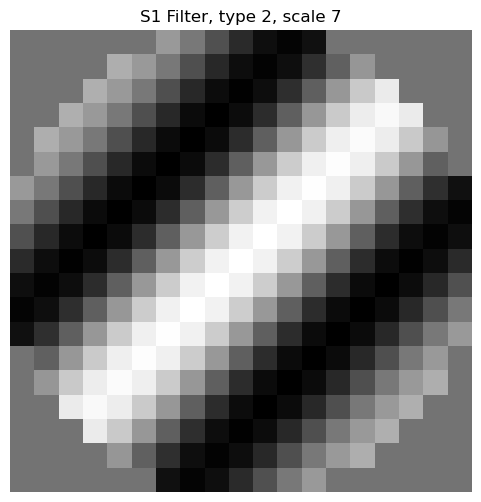

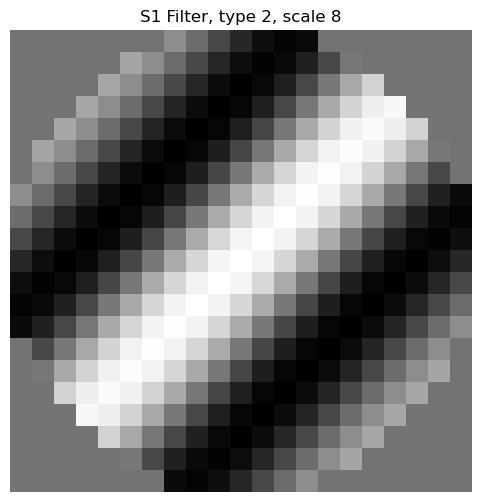

In [7]:
## S1 ##
# first execute lines 56 - 170 of hmax.py (def gabor_filter and class S1)
# then select a filter size and build S1 filters, for example:
S1_size7 = S1(size=19, wavelength=3.7) # spatial scale 7
S1_size8 = S1(size=21, wavelength=3.65) # spatial scale 8

# plot filte type 2 for each spatial scale
filter_type = 2

for filter_instance, scale in zip([S1_size7, S1_size8], [7, 8]):

    # create filter
    current_filter = filter_instance.gabor.weight.data[filter_type-1,0,:,:]

    plt.figure(figsize=(6, 6))
    plt.imshow(current_filter, cmap='gray')
    plt.title(f'S1 Filter, type {filter_type}, scale {scale}')
    plt.axis('off')
    plt.savefig(f's1_filter_scale{scale}_type{filter_type}.png', dpi=300, bbox_inches='tight')

Note that C1 does max pooling — there's no way to further visualize this step other than what we have already done in visualizing the response from C1 in the previous step.

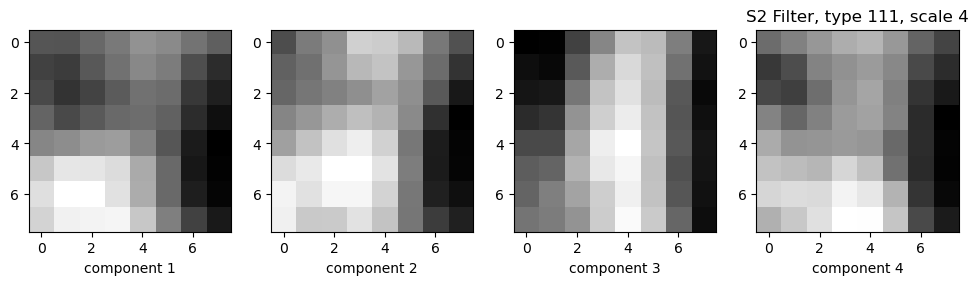

In [8]:
# Load S2 filters (patches)
hmax_pth = '/home/karnav/Documents/AM9624/labs/L6/2025_wk8_hmax'  # Replace with your path
os.chdir(hmax_pth)

# Load patch set
m = loadmat('universal_patch_set.mat')  
patches = [patch.reshape(shape[[2, 1, 0, 3]]).transpose(3, 0, 2, 1)
           for patch, shape in zip(m['patches'][0], m['patchSizes'].T)]

# there are 8 patches
patches_fscale1 = patches[0]
patches_fscale1.shape          # result = (400, 4, 2, 2) => 400 filters, 4 components, each 2x2 for scale 1

# Select the correct filter type and filter scale
filter_type = 111  
filter_scale = 4 

# Get the correct patch
selected_patch = patches[filter_scale-1][filter_type-1, :, :, :]  

# Plot the S2 filter (all 4 components)
fig, axs = plt.subplots(1, 4, figsize=(12, 6))
for dim3i in range(4):
    axs[dim3i].imshow(selected_patch[dim3i, :, :], cmap='gray')
    axs[dim3i].set_xlabel('component ' + str(dim3i+1))

plt.title(f'S2 Filter, type {filter_type}, scale {filter_scale}')
plt.savefig(f's2_filter_scale{filter_scale}_type{filter_type}.png', dpi=300, bbox_inches='tight')
plt.show()